# Code for the implementation of task IRIS


### Importing libraries

In [1]:
# For computation
import numpy as np
# For confusion matrices and plotting
from sklearn import metrics
import matplotlib.pyplot as plt

## 1.

### a) Importing labeled data for training and testing

In [2]:
class Dataset:
    def __init__(self, instances):
        data = {"training": {"targets": [], "features":[]}, "testing": {"targets": [], "features":[]}}
        labelToTarget = {"Iris-setosa": [1, 0, 0], "Iris-versicolor": [0, 1, 0], "Iris-virginica": [0, 0, 1]}
        for instance in instances:
            match instance.set:
                case 'training':
                    data["training"]["targets"].append(labelToTarget[instance.label])
                    data["training"]["features"].append(instance.features)
                case 'testing':
                    data["testing"]["targets"].append(labelToTarget[instance.label])
                    data["testing"]["features"].append(instance.features)
                    
        # convert to numpy array
        data["training"]["targets"] = np.array(data["training"]["targets"]).astype(float)
        data["training"]["features"] = np.array(data["training"]["features"]).astype(float)
        data["testing"]["targets"] = np.array(data["testing"]["targets"]).astype(float)
        data["testing"]["features"]  = np.array(data["testing"]["features"]).astype(float)
        
        self.data = data
        self.classes_names = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
        self.feature_names = ['Sepal length [cm]', 'Sepal width [cm]', 'Petal length [cm]', 'Petal width [cm]']
        self.colors = ['red', 'green', 'blue']
        self.DESCR = "Iris plants dataset"

In [3]:
class Instance:
    def __init__(self, features, label, set):
        self.features = features
        self.label = label
        self.set = set    

In [4]:
def loadDataSet(features_list: list):
    Instances = []
    path = "Iris_TTT4275/iris.data"
    n_classes = 3
    n_training = 30
    n_testing  = 20
    with open(path) as file:
        for _ in range(n_classes):
            for _ in range(n_training):
                line = file.readline()
                line = line.split(',')
                features = []
                for i in features_list:
                    features.append(line[i]) 
                label = line[-1].strip("\n")
                training_instance = Instance(features=features, label=label, set="training")
                Instances.append(training_instance)
            for _ in range(n_testing):
                line = file.readline()
                line = line.split(',')
                features = []
                for i in features_list:
                    features.append(line[i]) 
                label = line[-1].strip("\n")
                testing_instance = Instance(features=features, label=label, set="testing")
                Instances.append(testing_instance)
    return Dataset(Instances)

In [5]:
IRIS_Dataset = loadDataSet([0, 1, 2, 3])

### b) Training a linear classifier

## Training phase

In [6]:
# Activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [7]:
def TrainClassifier(dataset: Dataset, step_length: float, n_iterations, W_0: np.ndarray):
    W = W_0
    MSEs = []
    n_classes = 3
    n_training = 30
    for i in range(n_iterations):
        Gradient_MSE = np.zeros(W_0.shape)
        MSE = 0
        for index in range(n_classes * n_training):
            x_k = dataset.data["training"]["features"][index]
            x_k = np.append(x_k, 1)
            z_k = np.dot(W, x_k)
            g_k = sigmoid(z_k)
            t_k = dataset.data["training"]["targets"][index]
            MSE += 1/2 * np.dot((g_k - t_k).T,(g_k - t_k))
            Gradient_MSE += np.outer((g_k - t_k)*g_k*(np.ones((1,3))-g_k), x_k.T)
        W = W - step_length * Gradient_MSE
        MSEs.append(MSE)
    print(f"MSE in first iteration {MSEs[0]}, and last iteration {MSEs[-1]}\n")
    print(f"Our W is \n{W}\n")
    return W, MSEs

Choosing of step-length:

In [8]:
MSEs_with_diff_step_lengths = []
step_lengths = [0.00001, 0.001, 0.01, 0.09, 0.3, 0.6]
n = 10000
for alpha in step_lengths:
    MSEs_with_diff_step_lengths.append(TrainClassifier(IRIS_Dataset, alpha, n, np.zeros((3, 5)))[1])

MSE in first iteration 33.75, and last iteration 17.48193921483889

Our W is 
[[ 0.09689912  0.3855267  -0.62328669 -0.28104779  0.07162992]
 [-0.07462308 -0.23706361  0.13490341  0.0189384  -0.02671589]
 [-0.25812783 -0.31356555  0.44273138  0.26357462 -0.09944377]]

MSE in first iteration 33.75, and last iteration 8.959797430165688

Our W is 
[[ 0.3888711   1.50882521 -2.24949735 -1.03605253  0.27329594]
 [ 1.2995608  -2.50227686 -0.0826058  -1.16330458  0.94514486]
 [-2.41557891 -1.95751351  3.49481389  2.92009538 -1.34694791]]

MSE in first iteration 33.75, and last iteration 8.255067759838619

Our W is 
[[ 0.51442642  2.09090773 -3.08854801 -1.44619838  0.36972695]
 [ 1.3923658  -3.44966821 -0.33628089 -0.89657271  3.8632333 ]
 [-4.27680741 -3.95529838  6.43780056  6.48132611 -4.45128889]]

MSE in first iteration 33.75, and last iteration 30.440854325773333

Our W is 
[[-2.57350267 -0.76690481 -2.8562374  -1.0507316  -0.33739114]
 [-1.86751107 -1.21174335 -0.92432068 -0.30328134 -

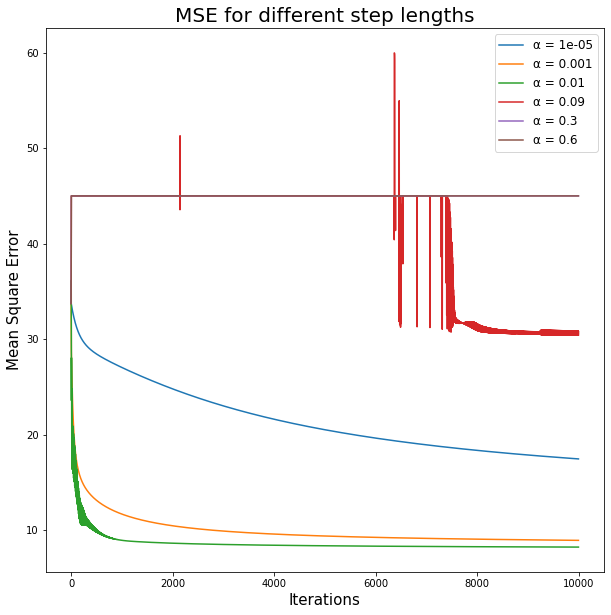

In [9]:
plt.figure(figsize=(10, 10))
for index ,MSEs in enumerate(MSEs_with_diff_step_lengths):
    plt.plot(MSEs, label=f'α = {str(step_lengths[index])}')
plt.legend(fontsize=12)
plt.title("MSE for different step lengths", fontsize=20)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Mean Square Error', fontsize=15)
plt.savefig(f"svg_figures/MSEvsAlpha.svg")
plt.show()

Therefore we choose alpha = 0.01 and n = 10'000 iterations. For the rest of the document. 

In [10]:
# Hyperparameters for the best classifier
alpha = 0.01
n = 10000

In [11]:
W_0 = np.zeros((3, 5))
W, _ = TrainClassifier(IRIS_Dataset, alpha, n, W_0)

MSE in first iteration 33.75, and last iteration 8.255067759838619

Our W is 
[[ 0.51442642  2.09090773 -3.08854801 -1.44619838  0.36972695]
 [ 1.3923658  -3.44966821 -0.33628089 -0.89657271  3.8632333 ]
 [-4.27680741 -3.95529838  6.43780056  6.48132611 -4.45128889]]



## Testing part

### Confusion Matrices.


In [12]:
def TestClassifier(dataset: Dataset, W: np.ndarray):
    n_classes = 3
    n_training = 30
    n_testing = 20
    ConfMatrices = {"training": np.zeros((n_classes, n_classes)), "testing": np.zeros((n_classes, n_classes)), "fileName": dataset.DESCR}
    errors = {"training": 0, "testing": 0}
    for index in range(n_classes * n_testing):
        x_k = IRIS_Dataset.data["testing"]["features"][index]
        x_k = np.append(x_k, 1)
        t_k = IRIS_Dataset.data["testing"]["targets"][index]
        g_k = np.dot(W, x_k)
        ConfMatrices["testing"][np.argmax(t_k), np.argmax(g_k)] += 1
        if np.argmax(t_k) != np.argmax(g_k):
            errors["testing"] += 1
    
    for index in range(n_classes * n_training):
        x_k = IRIS_Dataset.data["training"]["features"][index]
        x_k = np.append(x_k, 1)
        t_k = IRIS_Dataset.data["training"]["targets"][index]
        g_k = np.dot(W, x_k)
        ConfMatrices["training"][np.argmax(t_k), np.argmax(g_k)] += 1
        if np.argmax(t_k) != np.argmax(g_k):
            errors["training"] += 1
    
    print(f"Error-rates: \nTraining: {errors['training']/(n_training*n_classes)}, Testing: {errors['testing']/(n_classes*n_testing)}\n")
    return ConfMatrices

In [13]:
def PlotConfusionMatrix(matrix, fileName: str):
    plt.figure()
    
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    
    ax[0].set_title("Training set",fontsize=22)
    ax[1].set_title("Testing set", fontsize=22)
    metrics.ConfusionMatrixDisplay(confusion_matrix=matrix["training"], 
                                   display_labels=IRIS_Dataset.classes_names,
                                   ).plot(ax=ax[0], cmap="cividis")
    metrics.ConfusionMatrixDisplay(confusion_matrix=matrix["testing"],
                                   display_labels=IRIS_Dataset.classes_names,
                                   ).plot(ax=ax[1], cmap="cividis")
    plt.tight_layout()
    plt.suptitle(f"{fileName}", fontsize=20, x=0.11)
    plt.savefig(f"svg_figures/{fileName}.svg")
    plt.show()


### c)

Error-rates: 
Training: 0.011111111111111112, Testing: 0.03333333333333333



<Figure size 432x288 with 0 Axes>

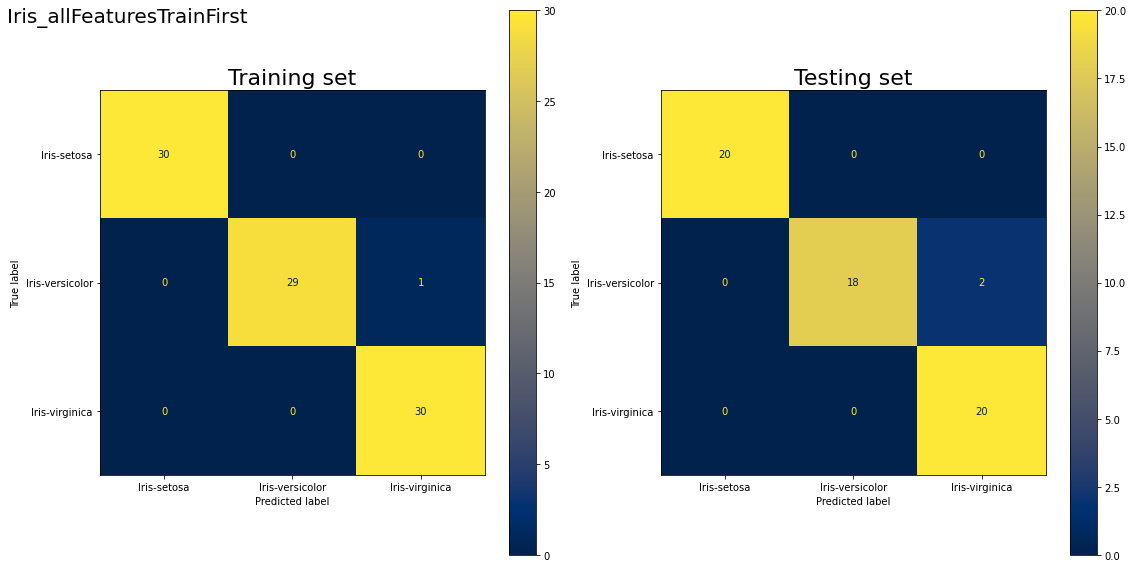

In [14]:
ConfMatrix = TestClassifier(IRIS_Dataset, W)
PlotConfusionMatrix(ConfMatrix, "Iris_allFeaturesTrainFirst")

### d)

In [15]:
path = "Iris_TTT4275/iris.data"
n_classes = 3
n_training = 30
n_testing  = 20

Instances = []

with open(path) as file:
    for _ in range(n_classes):
        for _ in range(n_testing):
            line = file.readline()
            line = line.split(',')
            features = line[0:-1]
            label = line[-1].strip("\n")
            testing_instance = Instance(features=features, label=label, set="testing")
            Instances.append(testing_instance)
            
        for _ in range(n_training):
            line = file.readline()
            line = line.split(',')
            features = line[0:-1]
            label = line[-1].strip("\n")
            training_instance = Instance(features=features, label=label, set="training")
            Instances.append(training_instance)
IRIS_Dataset = Dataset(Instances)

In [16]:
W_0 = np.zeros((3, 5))

W = W_0
MSEs = []
n_classes = 3
n_training = 30
for i in range(n):
    Gradient_MSE = np.zeros(W_0.shape)
    MSE = 0
    for index in range(n_classes * n_training):
        x_k = IRIS_Dataset.data["training"]["features"][index]
        x_k = np.append(x_k, 1)
        z_k = np.dot(W, x_k)
        g_k = sigmoid(z_k)
        t_k = IRIS_Dataset.data["training"]["targets"][index]
        MSE += 1/2 * np.dot((g_k - t_k).T,(g_k - t_k))
        Gradient_MSE += np.outer((g_k - t_k)*g_k*(np.ones((1,3))-g_k), x_k.T)
    W = W - alpha * Gradient_MSE
    MSEs.append(MSE)
print(f"MSE in first iteration {MSEs[0]}, and last iteration {MSEs[-1]}\n")
print(f"Our W is {W}\n")

MSE in first iteration 33.75, and last iteration 7.782250699388814

Our W is [[ 0.62149697  2.09879185 -3.32919137 -1.59596755  0.3846397 ]
 [-0.67042419 -2.72423632  2.48335887 -4.78915089  7.76357038]
 [-2.66215295 -4.33356959  4.94413712  6.41021334 -5.70359309]]



Error-rates: 
Training: 0.05555555555555555, Testing: 0.0



<Figure size 432x288 with 0 Axes>

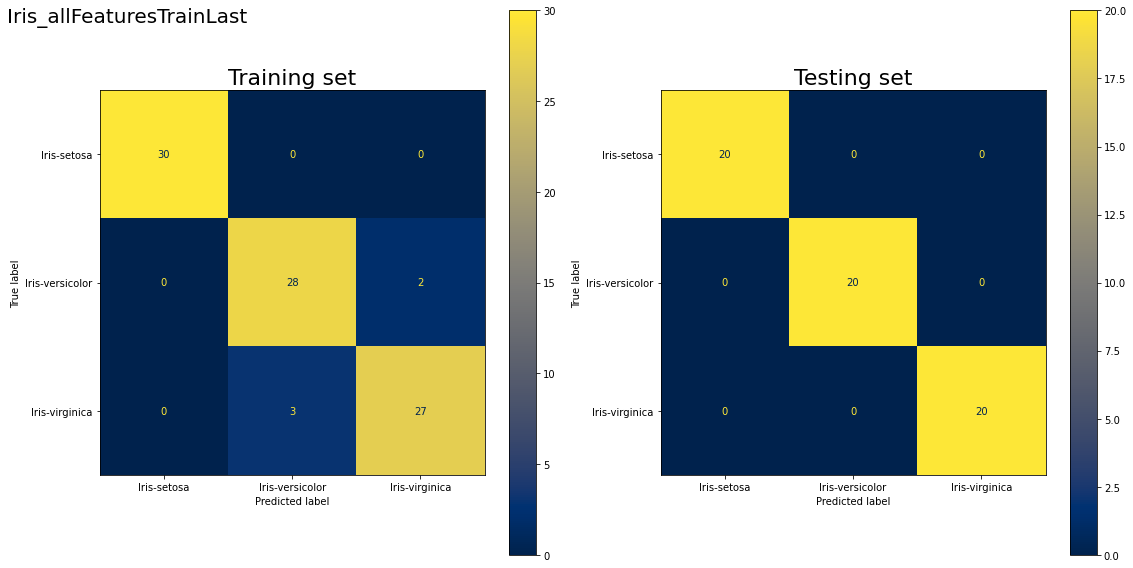

In [17]:
n_classes = 3
n_training = 30
n_testing = 20
ConfMatrix = {"training": np.zeros((n_classes, n_classes)), "testing": np.zeros((n_classes, n_classes)), "fileName": IRIS_Dataset.DESCR}
errors = {"training": 0, "testing": 0}
for index in range(n_classes * n_testing):
    x_k = IRIS_Dataset.data["testing"]["features"][index]
    x_k = np.append(x_k, 1)
    t_k = IRIS_Dataset.data["testing"]["targets"][index]
    g_k = np.dot(W, x_k)
    ConfMatrix["testing"][np.argmax(t_k), np.argmax(g_k)] += 1
    if np.argmax(t_k) != np.argmax(g_k):
        errors["testing"] += 1

for index in range(n_classes * n_training):
    x_k = IRIS_Dataset.data["training"]["features"][index]
    x_k = np.append(x_k, 1)
    t_k = IRIS_Dataset.data["training"]["targets"][index]
    g_k = np.dot(W, x_k)
    ConfMatrix["training"][np.argmax(t_k), np.argmax(g_k)] += 1
    if np.argmax(t_k) != np.argmax(g_k):
        errors["training"] += 1
print(f"Error-rates: \nTraining: {errors['training']/(n_training*n_classes)}, Testing: {errors['testing']/(n_classes*n_testing)}\n")
PlotConfusionMatrix(ConfMatrix, "Iris_allFeaturesTrainLast")

#TODO: Set dei ved siden av kvarandre. 

## 2

a)

In [18]:
n_examples = 50
paths = ["Iris_TTT4275/class_1", "Iris_TTT4275/class_2", "Iris_TTT4275/class_3"]
features = {paths[0]: [[], [], [], []], paths[1]:[[], [], [], []], paths[2]:[[], [], [], []]}
for i in range(len(paths)):
    with open(paths[i]) as file:
        for j in range(n_examples):
            line = file.readline().strip('\n').split(',')
            for k in range(len(line)):
                features[paths[i]][k].append(float(line[k]))

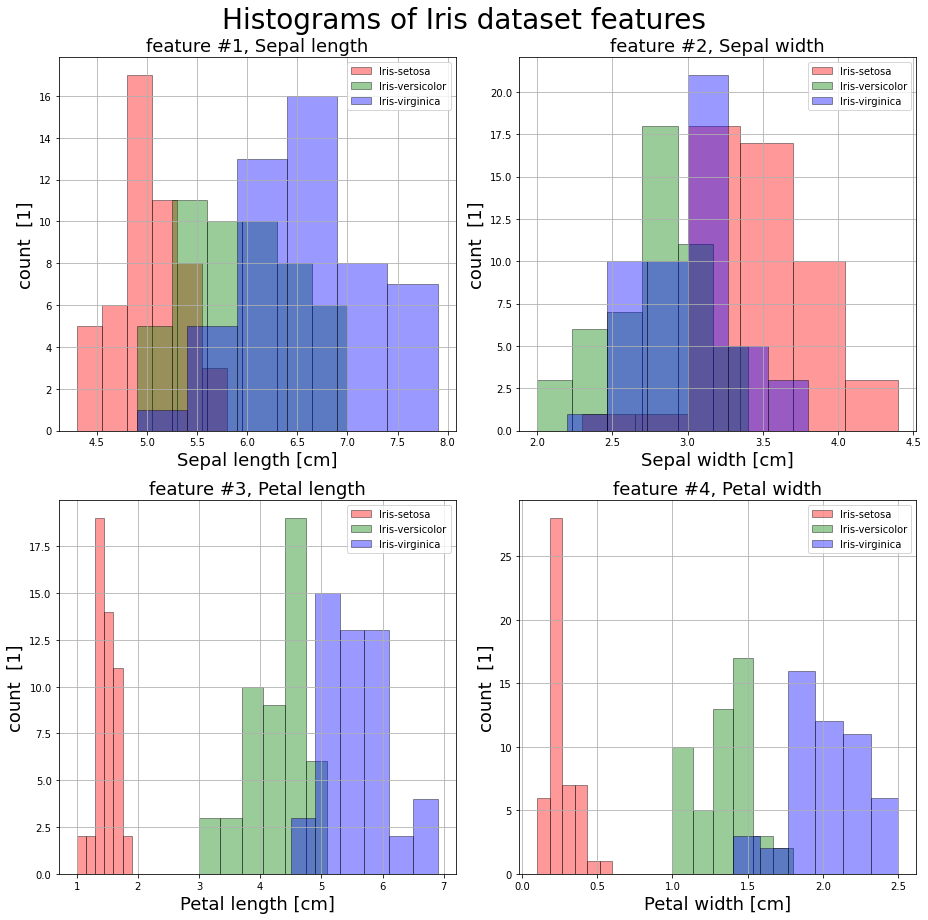

In [19]:
n_bars = 6
opacity = 0.4
plt.figure(figsize=(13,13))
plt.suptitle("Histograms of Iris dataset features", fontsize=28)
for index, feature in enumerate(IRIS_Dataset.feature_names):
    plt.subplot(2, 2, index+1)
    for class_nr in range(n_classes):
        plt.title(f"feature #{index+1}, {feature[:-5]}", fontsize=18)
        plt.hist(features[paths[class_nr]][index], label=IRIS_Dataset.classes_names[class_nr], bins=n_bars, alpha=opacity, edgecolor='black', color=IRIS_Dataset.colors[class_nr])
    plt.legend()
    plt.xlabel(feature, fontsize=18)
    plt.ylabel('count  [1]',fontsize=18)
    plt.grid()
plt.tight_layout()
plt.savefig("svg_figures/Iris_histograms.svg")
plt.show()

As Can be seen by the plots, feature 'Sepal width' is caotic and should be excluded. This is done below.

In [20]:
IRIS_Dataset = loadDataSet([0, 2, 3])

In [21]:
W_0 = np.zeros((3, 4))

W, _ = TrainClassifier(IRIS_Dataset, alpha, n, W_0)

MSE in first iteration 33.75, and last iteration 9.970641063314718

Our W is 
[[ 2.06484211 -3.89268238 -1.8971645   0.82725294]
 [-0.88064582  1.77221568 -2.98690418  1.13950512]
 [-5.04458306  6.14439924  4.66506643 -6.28938237]]



Error-rates: 
Training: 0.022222222222222223, Testing: 0.03333333333333333



<Figure size 432x288 with 0 Axes>

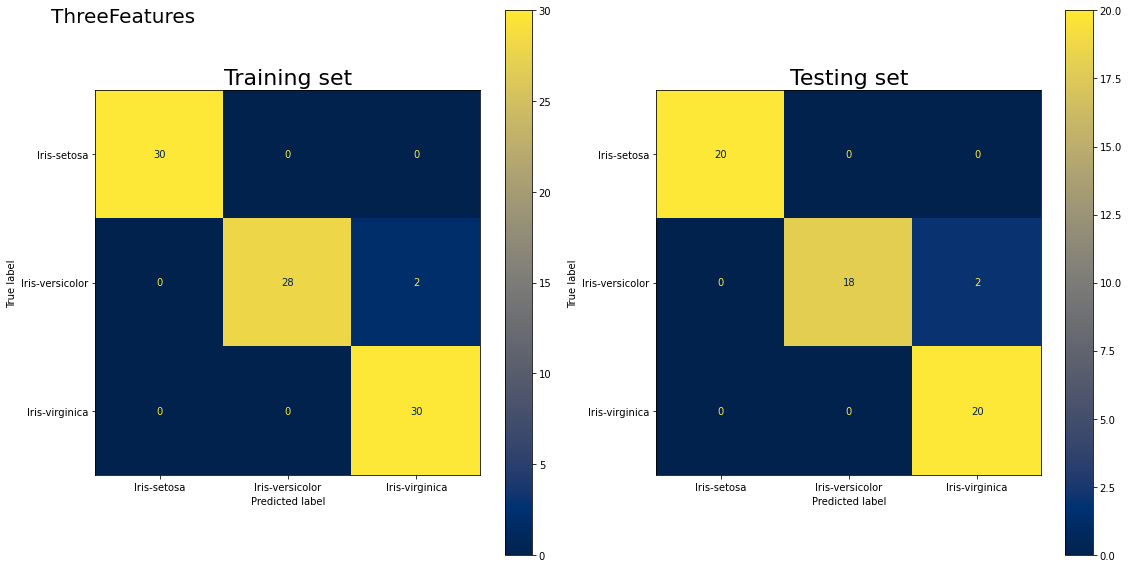

In [22]:
ConfMatrix = TestClassifier(IRIS_Dataset, W)

PlotConfusionMatrix(ConfMatrix, "ThreeFeatures")

### With only two features:  Petal width & length

In [23]:
IRIS_Dataset = loadDataSet([2, 3])

In [24]:
W_0 = np.zeros((3, 3))

W, _ = TrainClassifier(IRIS_Dataset, alpha, n, W_0)

MSE in first iteration 33.75, and last iteration 10.607999653994495

Our W is 
[[ -2.11310127  -3.09372891   7.64178215]
 [  1.22688415  -2.47790925  -2.32371546]
 [  1.06407806   5.97696536 -15.13713592]]



Error-rates: 
Training: 0.044444444444444446, Testing: 0.03333333333333333



<Figure size 432x288 with 0 Axes>

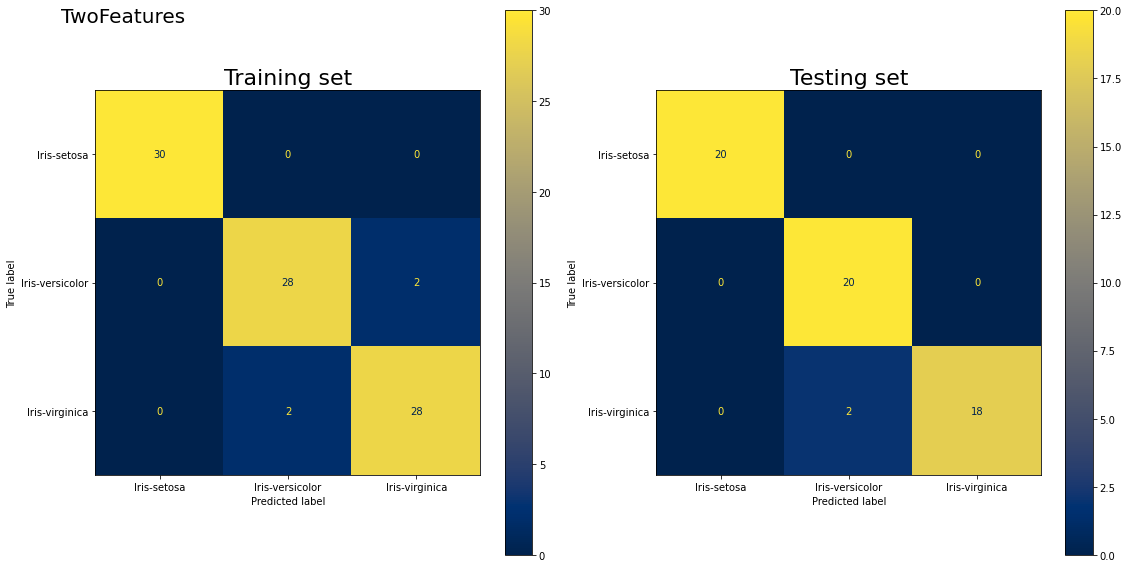

In [25]:
ConfMatrix = TestClassifier(IRIS_Dataset, W)

PlotConfusionMatrix(ConfMatrix, "TwoFeatures")

### And with only one feature (Petal width):

In [26]:
IRIS_Dataset = loadDataSet([3])

In [27]:
W_0 = np.zeros((3, 2))

W, _ = TrainClassifier(IRIS_Dataset, alpha, n, W_0)

MSE in first iteration 33.75, and last iteration 11.509213647205868

Our W is 
[[ -8.26332791   5.90017676]
 [  0.28291084  -1.02448386]
 [  8.10646641 -13.38616292]]



Error-rates: 
Training: 0.044444444444444446, Testing: 0.06666666666666667



<Figure size 432x288 with 0 Axes>

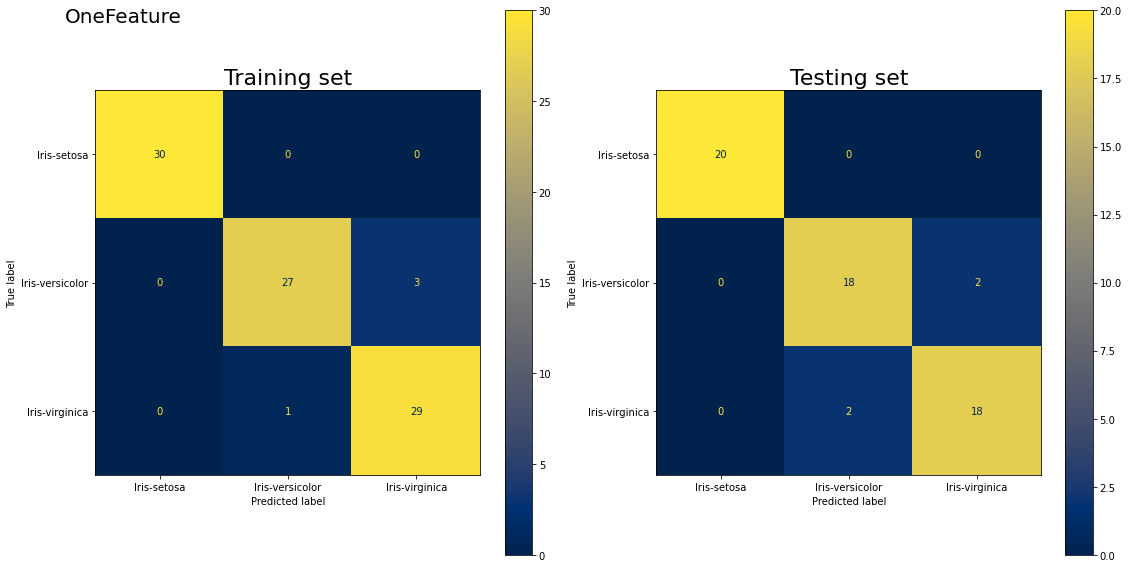

In [28]:
ConfMatrix = TestClassifier(IRIS_Dataset, W)

PlotConfusionMatrix(ConfMatrix, "OneFeature")

In order to comment on linear separability

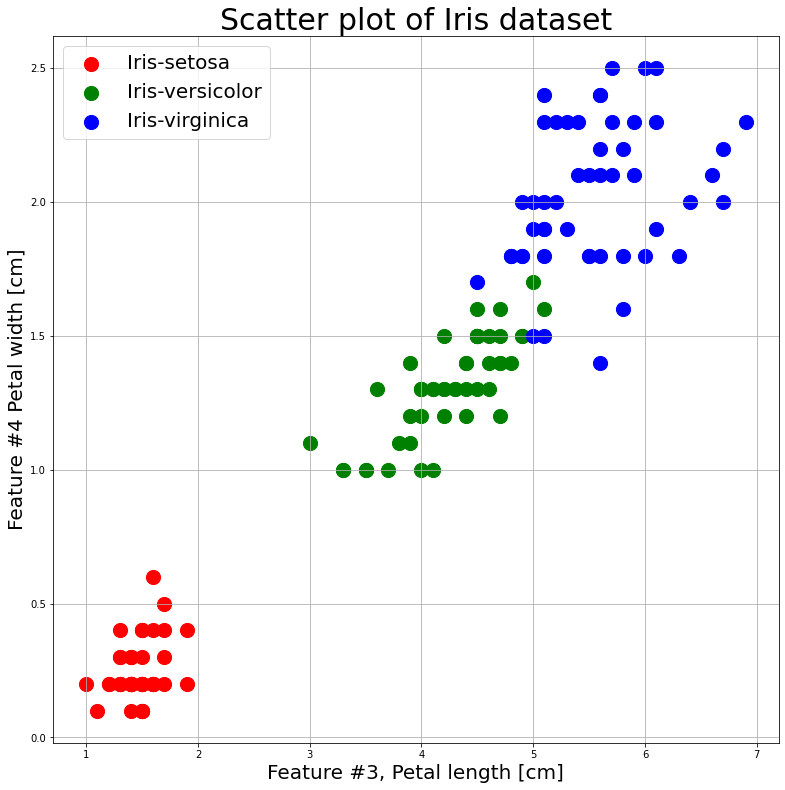

In [29]:
n_classes = 3
plt.figure(figsize=(13,13))
for index in range(n_classes):
    plt.scatter(features[paths[index]][2], features[paths[index]][3], label=IRIS_Dataset.classes_names[index], color=IRIS_Dataset.colors[index], s=200)
plt.legend(fontsize=20)
plt.grid()
plt.xlabel("Feature #3, Petal length [cm]", fontsize=20)
plt.ylabel("Feature #4 Petal width [cm]", fontsize=20)
plt.title("Scatter plot of Iris dataset", fontsize=30)
plt.savefig("svg_figures/Iris_scatter.svg")
plt.show()